# Babymoons: Are more babies born on the full moon?
## Code Louisville Data Analysis 2 Project

In [2]:
# Import modules

import pandas as pd
import seaborn as sns
from datetime import datetime
from scipy.stats import ttest_ind

## Feature 1: Loading Data
### Read at least two data files
3 csv files are used here

In [3]:
# Read in and inspect in Variables View

moon_df = pd.read_csv('full-moon-calendar-1900-2050/full_moon.csv')
births1_df = pd.read_csv('fivethirtyeight-births-dataset/US_births_1994-2003_CDC_NCHS.csv')
births2_df = pd.read_csv('fivethirtyeight-births-dataset/US_births_2000-2014_SSA.csv')

## Feature 2: Clean and operate on the data while combining them
### Clean Data
#### Check dataframes for null values

In [4]:
print(
    'births1_df nulls:\n', births1_df[births1_df.isna().any(axis=1)],
    '\n\nbirths2_df nulls:\n', births2_df[births2_df.isna().any(axis=1)],
    '\n\nmoon_df nulls:\n', moon_df[moon_df.isna().any(axis=1)]
)

births1_df nulls:
 Empty DataFrame
Columns: [year, month, date_of_month, day_of_week, births]
Index: [] 

births2_df nulls:
 Empty DataFrame
Columns: [year, month, date_of_month, day_of_week, births]
Index: [] 

moon_df nulls:
 Empty DataFrame
Columns: [Day,  Date,  Time]
Index: []


No null values found

#### Check data types and eliminate any extra whitespace

In [5]:
# Check data types

print(
    'births1_df dtypes:\n', births1_df.dtypes, 
    '\n\nbirths2_df dtypes:\n', births2_df.dtypes,
    '\n\nmoon_df dtypes:\n', moon_df.dtypes
)

births1_df dtypes:
 year             int64
month            int64
date_of_month    int64
day_of_week      int64
births           int64
dtype: object 

births2_df dtypes:
 year             int64
month            int64
date_of_month    int64
day_of_week      int64
births           int64
dtype: object 

moon_df dtypes:
 Day      object
 Date    object
 Time    object
dtype: object


In [6]:
# It looks there's some extra whitespace in the column names, let's check it out

print(
    'births1_df:\n', births1_df.columns,
    '\n\nbirths2_df:\n', births2_df.columns,
    '\n\nmoon_df:\n', moon_df.columns
)

births1_df:
 Index(['year', 'month', 'date_of_month', 'day_of_week', 'births'], dtype='object') 

births2_df:
 Index(['year', 'month', 'date_of_month', 'day_of_week', 'births'], dtype='object') 

moon_df:
 Index(['Day', ' Date', ' Time'], dtype='object')


In [7]:
# There's definitely leading whitespace in front of the moon_df column names - perform strip and view results

moon_df.columns = moon_df.columns.str.lstrip()

moon_df.columns

Index(['Day', 'Date', 'Time'], dtype='object')

In [8]:
# Remove any leading and trailing whitespace that might be present from the Day column in moon_df

moon_df['Day'].str.strip()

0          Monday
1       Wednesday
2          Friday
3          Sunday
4          Monday
          ...    
1863     Thursday
1864       Friday
1865       Sunday
1866       Monday
1867    Wednesday
Name: Day, Length: 1868, dtype: object

Everything looks as expected

#### Correct dates to YYYY-MM-DD format in all 3 datasets

In [9]:
# Start with moon_df, printing dtypes again to confirm successfully converted to datetime

moon_df['Date'] = pd.to_datetime(moon_df['Date'])

print(moon_df.dtypes, moon_df.head(), sep='\n\n')

Day             object
Date    datetime64[ns]
Time            object
dtype: object

         Day       Date          Time
0     Monday 1900-01-15   08:07:30 pm
1  Wednesday 1900-02-14   02:50:12 pm
2     Friday 1900-03-16   09:11:48 am
3     Sunday 1900-04-15   02:02:06 am
4     Monday 1900-05-14   04:36:36 pm


In [10]:
# Next do the birth datasets and check results

births1_df['Date'] = pd.to_datetime(births1_df.year.astype(str) + '-' + births1_df.month.astype(str) + '-' + births1_df.date_of_month.astype(str))

print(births1_df.head(3), births1_df.dtypes, sep='\n\n')

   year  month  date_of_month  day_of_week  births       Date
0  1994      1              1            6    8096 1994-01-01
1  1994      1              2            7    7772 1994-01-02
2  1994      1              3            1   10142 1994-01-03

year                      int64
month                     int64
date_of_month             int64
day_of_week               int64
births                    int64
Date             datetime64[ns]
dtype: object


In [11]:
births2_df['Date'] = pd.to_datetime(births2_df.year.astype(str) + '-' + births2_df.month.astype(str) + '-' + births2_df.date_of_month.astype(str))

print(births2_df.head(3), births2_df.dtypes, sep='\n\n')

   year  month  date_of_month  day_of_week  births       Date
0  2000      1              1            6    9083 2000-01-01
1  2000      1              2            7    8006 2000-01-02
2  2000      1              3            1   11363 2000-01-03

year                      int64
month                     int64
date_of_month             int64
day_of_week               int64
births                    int64
Date             datetime64[ns]
dtype: object


#### Combine birth datasets

In [12]:
# Combine birth data into one dataframe

births_df = pd.concat([births1_df, births2_df], ignore_index=True)

Looks good in Variables View

#### Drop duplicate dates since the datasets overlap from 2000-2003

In [13]:
# Check the starting number of rows

births_df.shape

(9131, 6)

In [14]:
# Drop rows that match on date and verify that rows have been dropped

births_df.drop_duplicates(subset=['Date'], keep='last', inplace=True)

births_df.shape

(7670, 6)

#### Replace day of week numbers with names in birth dataset

- We may want to look at births on different days of the week as part of our analysis

In [15]:
# According to kaggle documentation, 1 is Monday and 7 is Sunday

day_names_dict = {
                    1: 'Monday',
                    2: 'Tuesday',
                    3: 'Wednesday',
                    4: 'Thursday',
                    5: 'Friday',
                    6: 'Saturday',
                    7: 'Sunday'
                    }

In [16]:
# Create series of day numbers from births_df

day_numbers = births_df['day_of_week']

In [17]:
# Create day names series using series.map()

day_names = day_numbers.map(day_names_dict)

In [18]:
# Adding day names series to births_df using same column name as moon_df

births_df['Day'] = day_names

### Create final dataset
#### Perform a pandas merge

In [19]:
# Use Date columns to merge and keep everything in births_df, with only matching rows from moon_df

babymoons_df = pd.merge(births_df, moon_df, how = 'left', on = ['Date', 'Day'])

In [20]:
# Confirm that the number of rows equals that of births_df

babymoons_df.shape

(7670, 8)

Everything looks good in Variables View

#### Drop unnecessary columns

In [21]:
babymoons_df.drop(['year', 'month', 'date_of_month', 'day_of_week'], axis=1, inplace=True)
babymoons_df.head()

,births,Date,Day,Time
0,8096,1994-01-01,Saturday,NaN
1,7772,1994-01-02,Sunday,NaN
2,10142,1994-01-03,Monday,NaN
3,11248,1994-01-04,Tuesday,NaN
4,11053,1994-01-05,Wednesday,NaN


#### Indicate where full moons occur
- The Time column has been retained from moons_df, so any entry there that is not NaN represents a full moon
- We won't be using the times of the full moon, so we'll change the column to say "yes" or "no" for whether there was a full moon

In [22]:
# Fill in 'No' wherever NaN is present in Time column and confirm result

babymoons_df['Time'].fillna('No', inplace=True)

In [23]:
# Next, replace values in the Time column that don't say 'No' with 'Yes'

babymoons_df.loc[babymoons_df['Time'] != 'No','Time']='Yes'

In [24]:
# Rename Time column (and capitalize births column for consistency)

babymoons_df.rename(columns= {'births':'Births', 'Time':'Full Moon'}, inplace=True)
babymoons_df.columns

Index(['Births', 'Date', 'Day', 'Full Moon'], dtype='object')

## Feature 3: Visualize / Present Your Data
### Make 3 matplotlib/seaborn visualizations to display your data
#### Start looking at descriptive statistics and group by presence or absence of full moon

In [25]:
babymoons_df.groupby('Full Moon')['Births'].describe().round(1)

,count,mean,std,min,25%,50%,75%,max
Full Moon,,,,,,,,
No,7411.0,11174.5,2182.6,5728.0,8784.5,11983.0,12814.5,16081.0
Yes,259.0,11191.5,2208.5,6868.0,8863.5,11972.0,12832.0,15454.0


[Text(0.5, 1.0, 'Births by Full Moon Status')]

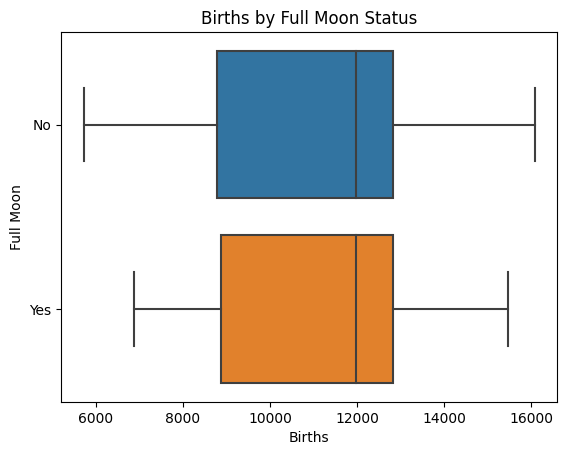

In [41]:
# It doesn't look like there's a big difference between full moon days and other days, but small differences can be significant
# Let's look at distributions with boxplots and histograms

sns.boxplot(babymoons_df, x='Births', y='Full Moon').set(title='Births by Full Moon Status')

[Text(0.5, 1.0, 'Births and Moons')]

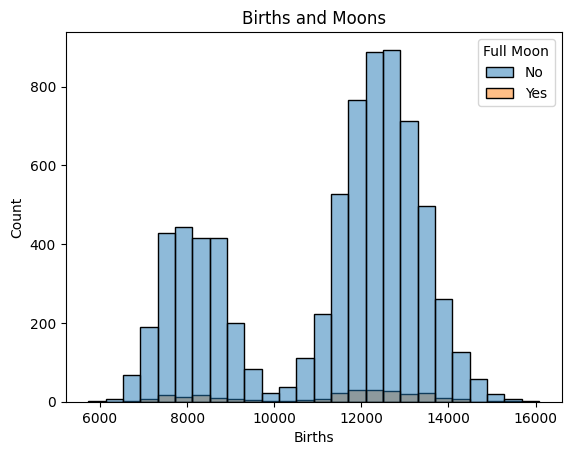

In [42]:
sns.histplot(babymoons_df, x='Births', hue = 'Full Moon').set(title="Births and Moons")

[Text(0.5, 1.0, 'Full Moon Births')]

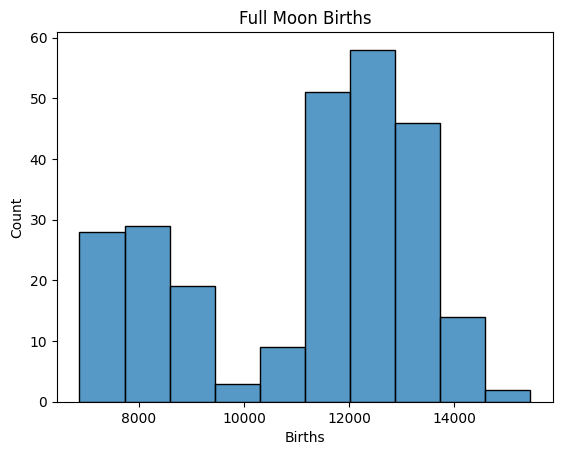

In [45]:
# Since there are fewer days with full moons, 
# let's isolate that set and check out the histogram to make sure the distributions are really the same shape

sns.histplot(babymoons_df[babymoons_df['Full Moon']=='Yes'], x='Births').set(title='Full Moon Births')

The distributions are bimodal, which means that our mean calculations are not accurately describing the center of the data, since there are really two centers.

According to https://www.statology.org/bimodal-distribution/, bimodal distributions are usually caused by an underlying phenomena or two different groups being lumped together without realizing it. To investigate what might be going on here, let's try looking at other aspects of the data to see if there are really two groups here.

#### Start with days of the week

[Text(0.5, 1.0, 'Births by Day of Week')]

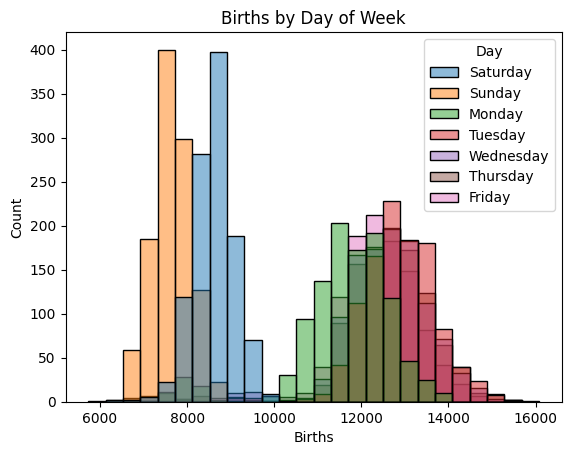

In [30]:
# Let's check out days of the week

sns.histplot(babymoons_df, x='Births', hue='Day').set(title='Births by Day of Week')

Saturdays and Sundays have a lot more births in the lower peak. Let's investigate further.

[Text(0.5, 1.0, 'Births by Day of Week')]

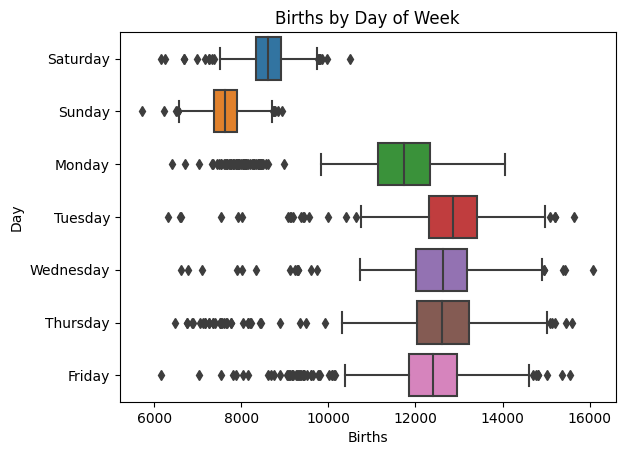

In [31]:
# Let's compare boxplots across the days of the week - maybe there will be less spread

sns.boxplot(babymoons_df, x='Births', y='Day').set(title='Births by Day of Week')

There could be a real difference between weekdays and weekends, so let's add a column for that to our dataframe

In [32]:
# Assign the weekend days to new column one at a time, then fill the rest with weekday designation.

babymoons_df.loc[babymoons_df['Day']=='Sunday', 'Part of Week'] = 'Weekend'
babymoons_df.loc[babymoons_df['Day']=='Saturday', 'Part of Week'] = 'Weekend'
babymoons_df['Part of Week'].fillna('Weekday', inplace=True)

[Text(0.5, 1.0, 'Weekends vs Weekdays')]

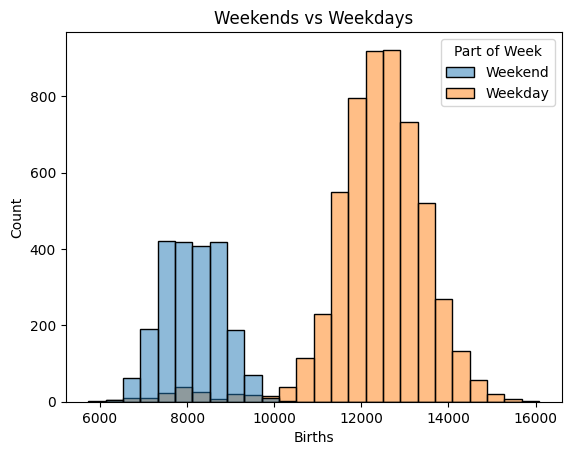

In [46]:
# Let's take a look at the distributions

sns.histplot(babymoons_df, x='Births', hue='Part of Week').set(title = 'Weekends vs Weekdays')

[Text(0.5, 1.0, 'Weekends vs Weekdays')]

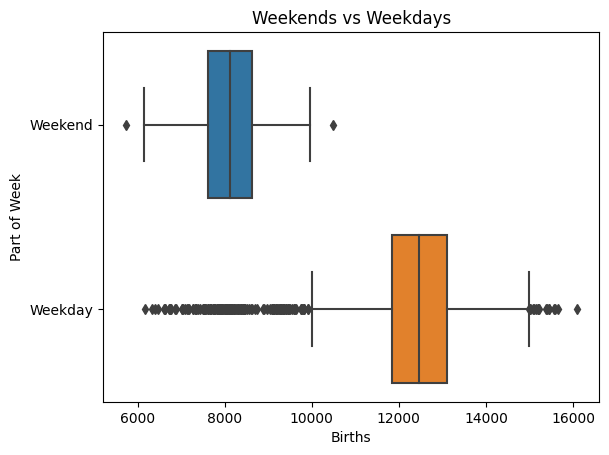

In [47]:
sns.boxplot(babymoons_df, x='Births', y='Part of Week').set(title='Weekends vs Weekdays')

This explains our bimodal distributions. 

#### Does splitting the data by part of week change the way our moon data looks?

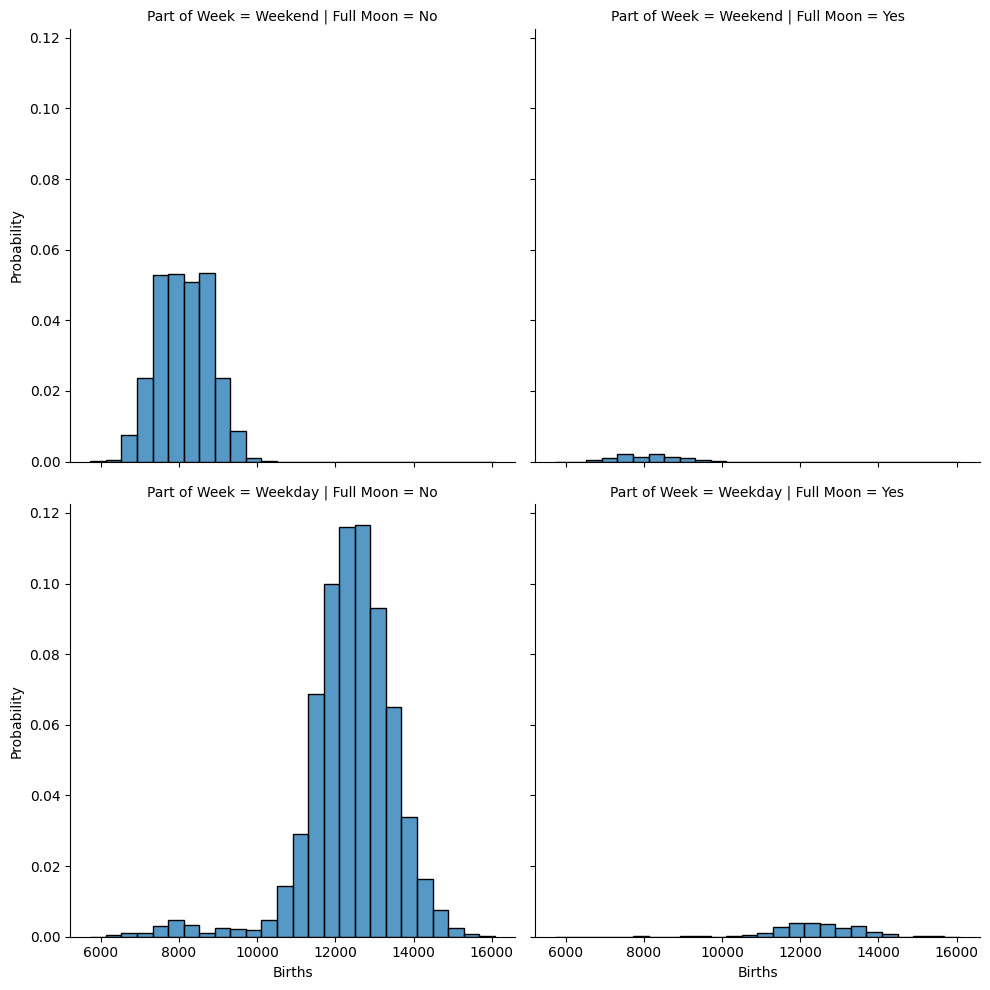

In [35]:
sns.displot(babymoons_df, x='Births', row='Part of Week', col='Full Moon', stat='probability')

It looks like the full moon births are distributed the same way as the non-full moon births. But, we can do a statistical test just to be sure.

#### Perform independent two sample t-tests to test weekends and weekdays separately.

In [48]:
# Define groups for t-test: weekends

weekend_group1 = babymoons_df.loc[(babymoons_df['Full Moon']=='Yes') & (babymoons_df['Part of Week']=='Weekend')]
weekend_group2 = babymoons_df.loc[(babymoons_df['Full Moon']=='No') & (babymoons_df['Part of Week']=='Weekend')]

In [49]:
# Perform t-test: weekends

ttest_ind(weekend_group1['Births'], weekend_group2['Births'])

Ttest_indResult(statistic=-0.4397424183844377, pvalue=0.6601670666050583)

The t-test shows that there is not a significant difference (p > 0.05) in the number of births on the weekends based on the presence or absence of a full moon.

Next, let's check the weekdays.

In [51]:
weekday_group1 = babymoons_df.loc[(babymoons_df['Full Moon']=='Yes') & (babymoons_df['Part of Week']=='Weekday')]
weekday_group2 = babymoons_df.loc[(babymoons_df['Full Moon']=='No') & (babymoons_df['Part of Week']=='Weekday')]

In [50]:
ttest_ind(weekday_group1['Births'], weekday_group2['Births'])

Ttest_indResult(statistic=1.005602473015432, pvalue=0.3146512661391731)

The t-test shows that there is not a significant difference (p > 0.05) in the number of births on the weekdays based on the presence or absence of a full moon.

# Conclusion: The data does not support the hypothesis that more babies are born on the full moon.